# **Simulador "2 Link Planar Robot" Con Ruido**

In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
from IPython.display import HTML
from scipy.integrate import solve_ivp

# la funcionalidad específica de robótica está en el toolbox
import roboticstoolbox as rtb
# spatialmath tiene define los grupos de transformaciones especiales: rotación SO3 y eculideo SE3
import spatialmath as sm
from spatialmath import SE3
import os
import time
from datetime import datetime
fecha_actual = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')

In [26]:
# Extiendo la clase DHRobot para que incluya el generador de trayectorias joint y cartesiano
from roboticstoolbox import DHRobot, RevoluteDH

class DHRobotGT(DHRobot):
  def __init__(self, *args, tacc=0.1, Ts=1E-3,vmax=np.array([2*np.pi,2*np.pi]), **kwargs):
    super().__init__(*args, **kwargs)
    self.tacc = tacc #Tiempo de aceleracion
    self.Ts = Ts #Intervalo de muestreo
    self.vmax = vmax #Velocidad maxima de las aceleraciones

  def interpoladorTrapezoidal(self,A,B,C,Tj):
    #Lo necesito para los movimientos en espacio de joints, para evitar que las aceleraciones sean deltas (limitacion en torques aplicados x dinamica inversa)
    """
    Interpolador trapezoidal en zona 1 y 2

    Args:
      A: punto en el que estoy
      B: punto al que estaba yendo en el segmento anterior
      C: punto al que voy
      Tj: tiempo en que se realiza el movimiento

    Returns:
      q_aux: vector interpolado de posiciones
      qd_aux: vector interpolado de velocidades
      qdd_aux: vector interpolado de aceleraciones
    """
    DA = A-B
    DC = C-B

    # Zona 1
    # Generar el vector tseg para Zona 1 -> Zona de aceleracion
    tseg = np.arange(-self.tacc + self.Ts, self.tacc + self.Ts, self.Ts) #

    # Calculo las referencias para zona 1
    qdd_aux = np.outer((DC/Tj+DA/self.tacc)/(2*self.tacc),np.ones(len(tseg)))
    qd_aux = (DC / Tj)[:, np.newaxis] * (tseg + self.tacc) / (2 * self.tacc) + (DA / self.tacc)[:, np.newaxis] * (tseg - self.tacc) / (2 * self.tacc)
    q_aux = (DC / Tj)[:, np.newaxis] * (tseg + self.tacc)**2 / (4 * self.tacc) + (DA / self.tacc)[:, np.newaxis] * (tseg - self.tacc)**2 / (4 * self.tacc) + np.outer(B,np.ones(len(tseg)))

    # Zona 2
    # Generar el vector tseg para Zona 2
    tseg = np.arange(self.tacc + self.Ts, Tj - self.tacc + 0.5* self.Ts , self.Ts)

    # Inicializar las matrices theta2p, thetap y theta
    qdd_aux = np.hstack([qdd_aux,np.zeros((len(B), len(tseg)))])   # Suponiendo que B es un vector
    qd_aux = np.hstack([qd_aux,np.outer(DC / Tj, np.ones(len(tseg)))])
    q_aux = np.hstack([q_aux,np.outer(DC / Tj, tseg) +  np.outer(B,np.ones(len(tseg)))])
    return q_aux,qd_aux,qdd_aux
  


  
  def genTrJoint(self, q_dest, Td):
    """
    Genera la trayectoria en el espacio de las articulaciones para un conjunto de puntos de paso usando interpolación trapezoidal.

    Args:
        q_dest: Matriz con los puntos de paso. Cada fila corresponde a un punto.
        Td: Tiempos deseados de cada movimiento.
        flag_q_noise: Indica si se añade ruido a las posiciones articulares.

    Returns:
        t: Vector de tiempo de referencia.
        q: Vector de posiciones articulares de referencia.
        qd: Vector de velocidades articulares de referencia.
        qdd: Vector de aceleraciones articulares de referencia.
        POSES: Vector de posiciones cartesianas de referencia (matrices A0_6 de cada posición).
    """
    # Inicializar listas para las posiciones, velocidades y aceleraciones articulares
    q = []
    qd = []
    qdd = []

    A = q_dest[0, :]

    for i in range(len(q_dest)):
        B = q_dest[i, :]
        if i < len(q_dest) - 1:
            C = q_dest[i + 1, :]
        else:
            C = B
            Td[i] = 0  # Si es el último segmento, el tiempo deseado es 0

        # Calcular el tiempo de movimiento
        Tj = np.max([np.max(np.abs(C - B) / self.vmax), Td[i], 2 * self.tacc])

        # Realizar la interpolación trapezoidal
        q_aux, qd_aux, qdd_aux = self.interpoladorTrapezoidal(A, B, C, Tj)
  

        # Acumulación de resultados
        q.append(q_aux)
        qd.append(qd_aux)
        qdd.append(qdd_aux)

        A = q_aux[:, -1]  # Actualizar el punto de inicio para el siguiente segmento

    # Convertir listas a arrays y aplanar para concatenar
    q = np.hstack(q)
    qd = np.hstack(qd)
    qdd = np.hstack(qdd)

    # Generar el vector de tiempo
    t = np.linspace(0, q.shape[1] * self.Ts, num=q.shape[1])

    # Calcular la trayectoria cartesiana deseada
    POSES = self.fkine(q.transpose())

    return t, q.transpose(), qd.transpose(), qdd.transpose(), POSES


  def genTrCart_2(self,POSE_dest,Td):
    """
    Genera la trayectoria cartesiana para un conjunto de puntos de paso

    Args:
      POSE_dest: Lista con las POSES de paso
      Td: tiempos deseados de cada movimiento

    Returns:
      t: Vector de tiempo de referencia
      q: Vector de posiciones articulares de referencia
      qd: Vector de velocidades articulares de referencia
      qdd: Vector de aceleraciones articulares de referencia
      POSES: Vector de posiciones cartesianas de referencia (Son las matrices A0_6 de cada posicion)
    """

    POSEA = POSE_dest[0]
    POSES = []
    for i in range(len(POSE_dest)):
      POSEB = POSE_dest[i]
      if i<len(POSE_dest)-1:
        POSEC = POSE_dest[i+1]
      else:
        C = B
        Td[i] = 0
      A = np.concatenate((POSEA.t,POSEA.eulervec()))
      B = np.concatenate((POSEB.t,POSEB.eulervec()))
      C = np.concatenate((POSEC.t,POSEC.eulervec()))
      Tj = np.max([Td[i],2*self.tacc])

      pos,_,_ = self.interpoladorTrapezoidal(A,B,C,Tj)
      POSES.extend([sm.SE3(pos[0:3,j])*sm.SE3.EulerVec(pos[3:,i]) for j in range(pos.shape[1])])

      POSEA = POSES[-1]

    q = np.zeros((len(POSES),self.nlinks))
    for i in range(len(POSES)):
      q[i,:],_ = self.ikine_a(POSES[i])


    # Obtengo la velocidad articular derivando numéricamente
    qd = np.diff(q, axis=0) / self.Ts
    # Ajustar la longitud de qd para que coincida con q
    qd = np.vstack([qd, np.zeros(self.nlinks,)])

    # Obtengo la aceleración articular derivando numéricamente
    qdd = np.diff(qd, axis=0) / self.Ts
    # Ajustar la longitud de qdd para que coincida con qd
    qdd = np.vstack([qdd, np.zeros(self.nlinks,)])

    t = np.linspace(0, len(q),num=len(q))*self.Ts
    return t,q,qd,qdd,POSES



  def genTrCar_2(self, POSE_dest, Td):
    POSEA = POSE_dest[0]
    POSES = []
    for i in range(len(POSE_dest)):
        POSEB = POSE_dest[i]
        if i < len(POSE_dest) - 1:
            POSEC = POSE_dest[i + 1]
        else:
            POSEC = POSEB  # Asegúrate de que POSEC no sea reutilizado incorrectamente
            Td[i] = 0

        A = np.concatenate((POSEA.t, POSEA.eulervec()))
        B = np.concatenate((POSEB.t, POSEB.eulervec()))
        C = np.concatenate((POSEC.t, POSEC.eulervec()))
        Tj = np.max([Td[i], 2 * self.tacc])

        # Realizar interpolación trapezoidal
        pos, _, _ = self.interpoladorTrapezoidal(A, B, C, Tj)

        # Asegurar interpolación correcta de las rotaciones
        for j in range(pos.shape[1]):
            transl = pos[0:3, j]
            rot = sm.SE3.EulerVec(pos[3:, j])
            pose = sm.SE3(transl) * rot
            POSES.append(pose)

        POSEA = POSES[-1]

    # Resolver la cinemática inversa para todas las poses
    q = np.zeros((len(POSES), self.nlinks))
    for i in range(len(POSES)):
        q[i, :], _ = self.ikine_a(POSES[i])

    # Derivar numéricamente para obtener qd y qdd
    qd = np.diff(q, axis=0) / self.Ts
    qd = np.vstack([qd, np.zeros(self.nlinks,)])

    qdd = np.diff(qd, axis=0) / self.Ts
    qdd = np.vstack([qdd, np.zeros(self.nlinks,)])

    t = np.linspace(0, len(q), num=len(q)) * self.Ts
    return t, q, qd, qdd, POSES
  
  def genTrCart(self, POSE_dest, Td, flag_p_noise=False):
    """
    Genera una trayectoria cartesiana a partir de una lista de poses destino usando interpolación trapezoidal.

    Args:
        POSE_dest: Lista de poses destino.
        Td: Duración de cada segmento de la trayectoria.
        flag_p_noise: Indica si se añade ruido a las posiciones cartesianas.

    Returns:
        t: Vector de tiempo de referencia.
        q: Posiciones articulares.
        qd: Velocidades articulares.
        qdd: Aceleraciones articulares.
        POSES: Lista de poses cartesianas generadas.
    """
    POSEA = POSE_dest[0]
    POSES = []

    for i in range(len(POSE_dest)):
        POSEB = POSE_dest[i]
        if i < len(POSE_dest) - 1:
            POSEC = POSE_dest[i + 1]
        else:
            POSEC = POSEB  # Asegúrate de que POSEC no sea reutilizado incorrectamente
            Td[i] = 0

        A = np.concatenate((POSEA.t, POSEA.eulervec()))
        B = np.concatenate((POSEB.t, POSEB.eulervec()))
        C = np.concatenate((POSEC.t, POSEC.eulervec()))
        Tj = np.max([Td[i], 2 * self.tacc])

        # Realizar interpolación trapezoidal
        pos, vel, acc = self.interpoladorTrapezoidal(A, B, C, Tj)

        # Añadir ruido a las velocidades y aceleraciones cartesianas si se especifica
        if flag_p_noise:
           pos += np.random.normal(0, 0.01, pos.shape)
        
        # Asegurar interpolación correcta de las rotaciones
        for j in range(pos.shape[1]):
            transl = pos[0:3, j]
            rot = sm.SE3.EulerVec(pos[3:, j])
            pose = sm.SE3(transl) * rot
            POSES.append(pose)

        POSEA = POSES[-1]

    # Resolver la cinemática inversa para todas las poses
    q = np.zeros((len(POSES), self.nlinks))

    for i in range(len(POSES)):
        q[i, :], _ = self.ikine_a(POSES[i])

    # Derivar numéricamente para obtener qd y qdd
    qd = np.diff(q, axis=0) / self.Ts
    qd = np.vstack([qd, np.zeros((1, self.nlinks))])  # Añadir ceros al final para mantener el tamaño

    qdd = np.diff(qd, axis=0) / self.Ts
    qdd = np.vstack([qdd, np.zeros((1, self.nlinks))])  # Añadir ceros al final para mantener el tamaño

    # Generar vector de tiempo
    t = np.linspace(0, len(q) * self.Ts, num=len(q))

    return t, q, qd, qdd, POSES


In [27]:
# Preparo el modelo de un doble péndulo
class DoublePendulum(DHRobotGT):
  def __init__(self, L1, L2, m1, m2, xg1, xg2, Ig1, Ig2, B1=1, B2=1, G1=1, G2=1, *args,**kwargs):
    # Definición de los enlaces usando parámetros DH
    eje1 = RevoluteDH(a=L1,alpha=0,m=m1,
            r=np.array([xg1, 0, 0]),
            I=np.array([0,0,0,0,0,0,0,0,Ig1]),
            B=B1, G=G1)
    eje2 = RevoluteDH(a=L2,alpha=0,m=m2,
            r=np.array([xg2, 0, 0]),
            I=np.array([0,0,0,0,0,0,0,0,Ig2]),
            B=B2, G=G2)
    self.link_lengths = [L1, L2]

    # Crear la estructura del robot
    super().__init__(*args,[eje1, eje2], name='DoublePendulum',gravity = np.array([0, -9.8, 0]),**kwargs)

  def ikine_a(self, POSE, conf=1): #La cinematica inversa no esta planteada de forma analitica https://petercorke.github.io/robotics-toolbox-python/IK/ik.html#ik
    """
    Cinemática inversa analítica

    Args:
      POSE: Posición y orientación en el espacio
      config: configuración del codo (-1 ó 1)

    Returns:
      q: Posiciones articulares
      status: Estado del algoritmo de cálculo (<0 es error)
    """
    conf = 1 if conf >= 0 else -1

    q = np.zeros((2,));
    px, py, pz = POSE.t
    a1 = self.links[0].a
    a2 = self.links[1].a

    if (px**2+py**2)>(a1+a2)**2:
      status = -1;
      print(f"El punto ({px:.2f},{py:.2f}) no es alcanzable");
    elif (px**2+py**2)<1E-10:
      status = 0;
      q[0] = 0;
      q[1] = np.pi;
    else:
      c2 = (px**2+py**2-(a1**2+a2**2))/(2*a1*a2);
      s2 = conf * math.sqrt(1-c2**2);
      q[1] = math.atan2(s2,c2);

      s1 = (a2*(py*c2-px*s2)+a1*py)/(px**2+py**2);
      c1 = (a2*(py*s2+px*c2)+a1*px)/(px**2+py**2);
      q[0] = math.atan2(s1,c1);
      status = 0;
    return q,status
  
  def fkine_matrixes(self, set_qs):
    #fkines = self.fkine_all(q=set_qs)
    #fkinemat = []
    #for item in range(len(fkines)):
    #    fkinemat.append(np.matrix(fkines[item]))
    #return fkinemat
    #return [np.matrix(fk) for fk in self.fkine_all(q=set_qs)]
    return [np.array(fk.A) for fk in self.fkine_all(q=set_qs)]


  def show(self, set_qs):
      fkinemat = self.fkine_matrixes(set_qs)
      #Posiciones de los joints en 2D (en [x,y])
      joint1_position = fkinemat[1][0:3,3].flatten()
      joint2_position = fkinemat[2][0:3,3].flatten()
      # Print positions for debugging
      print("Joint 1 Position:", joint1_position)
      print("Joint 2 Position:", joint2_position)
      # Plot the robot
      fig, ax = plt.subplots()
      # Plot links
      ax.plot([0, joint1_position[0], joint2_position[0]],
              [0, joint1_position[1], joint2_position[1]], 'bo-')
      # Plot joints
      ax.plot(0, 0, 'ro')  # Base joint
      ax.plot(joint1_position[0], joint1_position[1], 'ro')  # Joint 1
      ax.plot(joint2_position[0], joint2_position[1], 'ro')  # Joint 2
      # Set axis limits
      ax.set_xlim([-(1.5)*self.link_lengths[0] - self.link_lengths[1] , (1.5)*self.link_lengths[0] + self.link_lengths[1]])
      ax.set_ylim([-(1.5)*self.link_lengths[0] - self.link_lengths[1] , (1.5)*self.link_lengths[0] + self.link_lengths[1]])
      # Set aspect ratio to equal
      ax.set_aspect('equal', adjustable='box')
      ax.grid()

      plt.show()
      #plt.close(fig)
      return #fig  
  

  def show_animation(self, trajectory, total_time, tcp_trajectory=None):
      fig, ax = plt.subplots()
      frames = len(trajectory)
      interval = (total_time * 1000) / frames

      def update(frame):
          ax.clear()
          # Set axis limits
          ax.set_xlim([-(1.5)*self.link_lengths[0] - self.link_lengths[1] , (1.5)*self.link_lengths[0] + self.link_lengths[1]])
          ax.set_ylim([-(1.5)*self.link_lengths[0] - self.link_lengths[1] , (1.5)*self.link_lengths[0] + self.link_lengths[1]])
          # Set aspect ratio to equal
          ax.set_aspect('equal', adjustable='box')
          ax.grid()

          # Plot the trajectory
          if tcp_trajectory is not None:
            ax.plot([pose[0] for pose in tcp_trajectory[:frame+1]], [pose[1] for pose in tcp_trajectory[:frame+1]], 'k--', label='TCP Trajectory')
          # Plot the robot at the current configuration
          #self.set_joint_angles(*trajectory[frame]
          fkinemat = self.fkine_matrixes(set_qs=trajectory[frame])
          #Posiciones de los joints en 2D (en [x,y])
          joint1_position = fkinemat[1][0:3,3].flatten()
          joint2_position = fkinemat[2][0:3,3].flatten()

          ax.plot([0, joint1_position[0], joint2_position[0]],
                  [0, joint1_position[1], joint2_position[1]], 'bo-')

          ax.plot(0, 0, 'ro')  # Base joint
          ax.plot(joint1_position[0], joint1_position[1], 'ro')  # Joint 1
          ax.plot(joint2_position[0], joint2_position[1], 'ro')  # Joint 2

      # Animar al robot a lo largo de la trayectoria segun el numero de pasos
      ani = FuncAnimation(fig, update, frames=frames, interval=interval) #interval

      # Para mostrar la simulación
      #plt.show()
      plt.close()#Agregar esta linea sirve para q el modo interactivo plotee pero no muestre plots extra cuando llamo a la animacion
      return HTML(ani.to_jshtml())


# Crear una instancia del doble péndulo
dp = DoublePendulum(0.2, 0.2, 1.5, 1, -0.1, -0.1, 1E-3, 1E-3, 0.5, 0.5, Ts=1E-3,tacc=0.2,vmax=np.array([2*np.pi,2*np.pi]))

qr = np.array([-np.pi/2,0])
qz = np.zeros((2,))

print(dp)
print(dp.dynamics()) #print(dp.dynamics_list())

DHRobot: DoublePendulum, 2 joints (RR), dynamics, standard DH parameters
┌─────┬────┬─────┬──────┐
│ θⱼ  │ dⱼ │ aⱼ  │  ⍺ⱼ  │
├─────┼────┼─────┼──────┤
│  q1 │  0 │ 0.2 │ 0.0° │
│  q2 │  0 │ 0.2 │ 0.0° │
└─────┴────┴─────┴──────┘

┌──┬──┐
└──┴──┘

┌───────┬──────┬──────────────┬────────────────────────────┬────┬──────┬────────┬────┐
│   j   │  m   │      r       │             I              │ Jm │  B   │   Tc   │ G  │
├───────┼──────┼──────────────┼────────────────────────────┼────┼──────┼────────┼────┤
│ link1 │  1.5 │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0 │  0 │  0.5 │  0,  0 │  1 │
│ link2 │  1   │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0 │  0 │  0.5 │  0,  0 │  1 │
└───────┴──────┴──────────────┴────────────────────────────┴────┴──────┴────────┴────┘

None


Joint 1 Position: [0.2 0.  0. ]
Joint 2 Position: [0.4 0.  0. ]


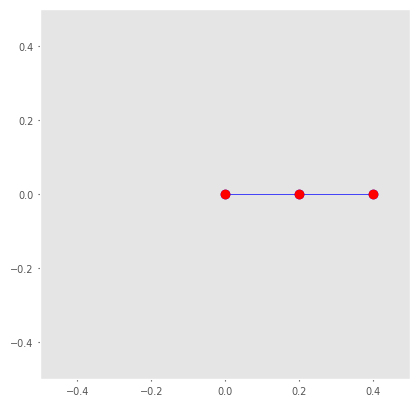

In [28]:
dp.show(set_qs=[0.0,0.0])

# Generación de Datos Randomizados #

In [29]:
def generarRandomSamples(robot,N_samples=50000,show_histo=False):
  np.random.seed(42)            # Para reproducibilidad

  # Genero valores aleatorios para posición de los ejes y sus derivadas
  # 2 7 35
  q = 2*np.random.randn(N_samples, robot.nlinks)
  qd = 7*np.random.randn(N_samples, robot.nlinks)
  qdd = 35*np.random.randn(N_samples, robot.nlinks)

  tau = robot.rne(q,qd,qdd)

  if show_histo:
    num_features_X = 6
    for i in range(num_features_X):
        plt.subplot(3, 2, i + 1)
        plt.hist(X_back[:, i], bins=30, alpha=0.7, color='green', edgecolor='black')
        #plt.title(f'Histograma de X{i+1}')
        #plt.xlabel('Valor')
        #plt.ylabel('Frecuencia')
    plt.show()

    num_features_Y = 2
    for i in range(num_features_Y):
        plt.subplot(1, num_features_Y, i + 1)
        plt.hist(Y_back[:, i], bins=30, alpha=0.7, color='green', edgecolor='black')
        plt.title(f'Histograma de torques{i+1}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
    plt.show()
  return q,qd,qdd,tau


In [30]:
def generateRandomDataSet(robot,N_segments,flag_joint_move=False,flag_plot=False,flag_q_noise=False, pos_noise_std=1e-6):
  """Genera un dataset para entrenamiento y pruebas

  Args:
    robot: Instancia del robot
    N_segments: Cantidad de puntos a visitar (fly by point). El movimiento empieza y termina con velocidad 0
    flag_joint_move: Indica si la secuencia de movimientos es joint o cartesiana
    flag_plot: Indica si se grafica la trayectoria deseada

  Returns:
    t_ref: Vector de tiempo de referencia
    q_ref: Vector de posiciones articulares de referencia
    qd_ref: Vector de velocidades articulares de referencia
    qdd_ref: Vector de aceleraciones articulares de referencia
    POSES_ref: Vector de posiciones cartesianas de referencia (Son las matrices A0_6 de cada posicion)
    tau_ref: Vector de torques de referencia calculado con la dinámica directa para realizar la trayectoria de referencia

  """
  alcanceXY = robot.a[0]+robot.a[1]
  Tj = np.random.rand(N_segments, )+0.5
  q_med = []
  if flag_joint_move:
    q_dest = (np.random.rand(N_segments, 2)-0.5)*2*np.pi
    t_ref,q_ref,qd_ref,qdd_ref,POSES_ref = robot.genTrJoint(q_dest,Tj)
    if flag_q_noise:
        #q_med = q_dest + np.random.normal(0, pos_noise_std, q_dest.shape)
        #t_med,q_ref,qd_ref,qdd_ref,POSES_ref = robot.genTrJoint(q_dest,Tj)
        q_med = q_ref + np.random.normal(0, pos_noise_std, q_ref.shape)
  else:
    # Limito las poses destino para trabajar en 2 cuadrantes y evitar pasar por singularidades
    POSE_dest = []
    while len(POSE_dest) < N_segments:
      x_dest = np.random.uniform(0, alcanceXY)
      y_dest = np.random.uniform(-alcanceXY, alcanceXY)
      if x_dest**2 + y_dest**2 < alcanceXY**2:
        POSE_dest.append(sm.SE3(x_dest, y_dest, 0))
    t_ref,q_ref,qd_ref,qdd_ref,POSES_ref = robot.genTrCart(POSE_dest,Tj)


  # Extraigo la posición del TCP para graficar
  pos_ref = np.vstack(([pose.t[0] for pose in POSES_ref], [pose.t[1] for pose in POSES_ref])).T

  # Obtengo la velocidad cartesiana derivando numéricamente
  posd_ref = np.diff(pos_ref, axis=0) / robot.Ts
  # Ajustar la longitud de qdd para que coincida con qd
  posd_ref = np.vstack([posd_ref, np.zeros(2,)])

  # Obtengo la aceleración cartesiana derivando numéricamente
  posdd_ref = np.diff(posd_ref, axis=0) / robot.Ts
  # Ajustar la longitud de qdd para que coincida con qd
  posdd_ref = np.vstack([posdd_ref, np.zeros(2,)])

  # Calculo con el PDI el torque para hacer esa trayectoria
  tau_ref = robot.rne(q_ref,qd_ref,qdd_ref)

  if flag_plot:
    # Graficar los resultados
    plt.figure(figsize=(12, 12))
    # Muestro las variables joint deseadas
    plt.subplot(3,1,1)
    plt.plot(t_ref,q_ref)
    plt.plot(t_ref,q_med)
    plt.legend(['q1', 'q2']);  plt.ylabel('q')
    plt.title('Variables articulares de referencia')
    plt.subplot(3,1,2)
    plt.plot(t_ref,qd_ref)
    plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
    plt.subplot(3,1,3)
    plt.plot(t_ref,qdd_ref)
    plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
    plt.show()

    # Muestro las variables cartesianas deseadas
    plt.figure(figsize=(12, 12))
    plt.subplot(3,1,1)
    plt.plot(t_ref,pos_ref)
    plt.legend(['x', 'y']);  plt.ylabel('Posición')
    plt.title('Variables cartesianas de referencia')
    plt.subplot(3,1,2)
    plt.plot(t_ref,posd_ref)
    plt.legend(['vx', 'vy']);  plt.ylabel('Velocidad')
    plt.subplot(3,1,3)
    plt.plot(t_ref,posdd_ref)
    plt.legend(['a1', 'a2']); plt.xlabel('Tiempo'); plt.ylabel('Aceleración')
    plt.show()

    # Muestro la trayectoria deseada
    fig,ax = plt.subplots()
    plt.plot(pos_ref[:,0],pos_ref[:,1])
    circle = Circle((0, 0), alcanceXY,edgecolor='b', facecolor='none', linestyle='--')
    ax.add_patch(circle)
    plt.xlabel('x'); plt.ylabel('y')
    plt.title(' Trayectoria de referencia')
    plt.axis('equal')
    plt.show()

    plt.figure(figsize=(12, 12))
    plt.plot(t_ref,tau_ref)
    plt.legend(['tau1', 'tau2']); plt.xlabel('Tiempo'); plt.ylabel('Torque')
    plt.title('Torque calculado para realizar trayectoria')
    plt.show()

    plt.figure(figsize=(12, 8))
    plt.plot(t_ref,q_ref, label='Q de Referencia')
    plt.plot(t_ref,q_med, label='Q Ruido')
    plt.legend(loc='upper right', fontsize=10)
    plt.xlabel('Tiempo'); plt.ylabel('Q')
    plt.title('Variables articulares')
    plt.show()

  return t_ref,q_ref,qd_ref,qdd_ref,POSES_ref,tau_ref, q_med

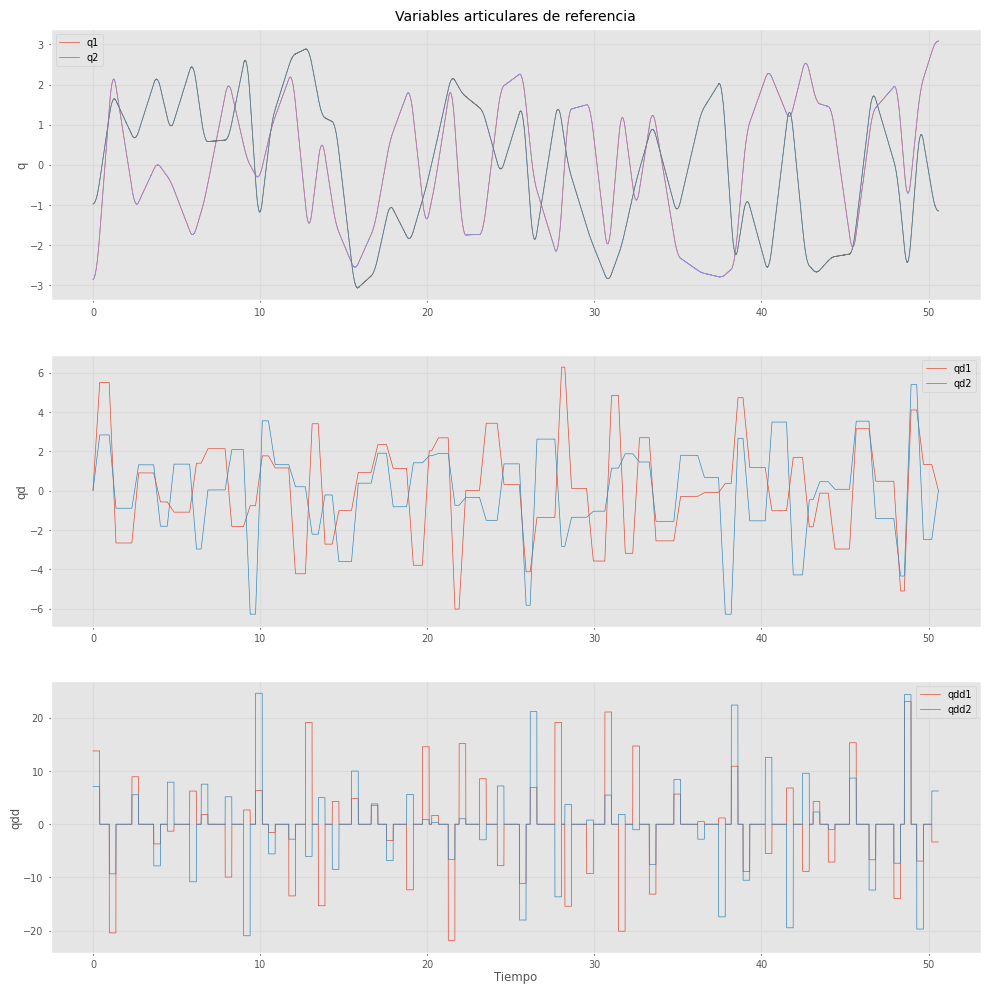

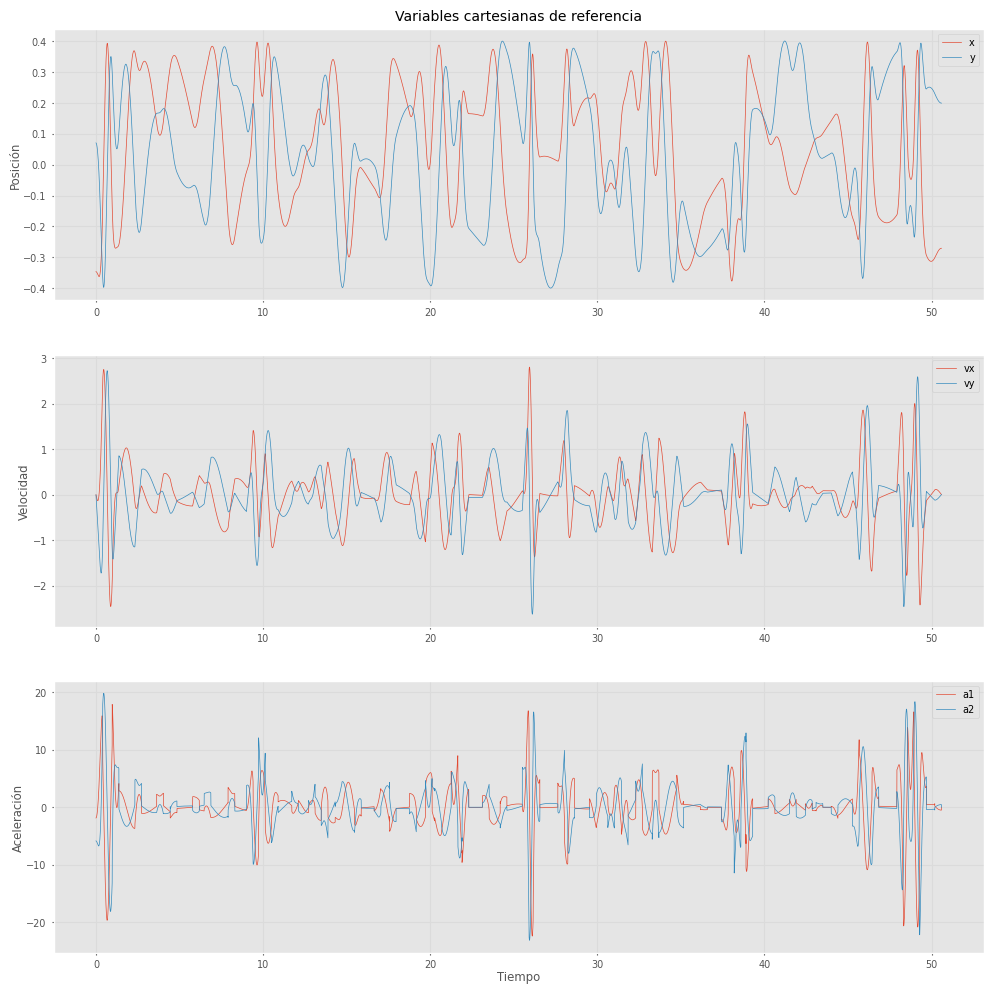

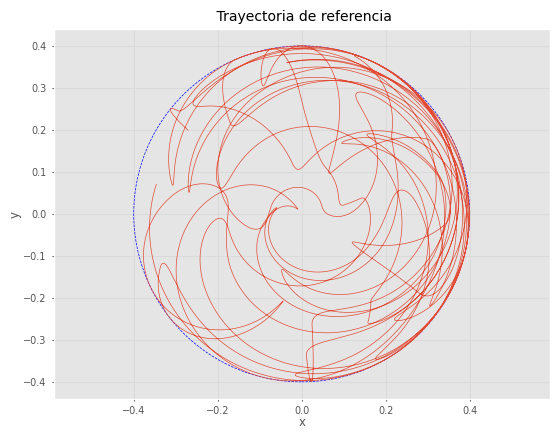

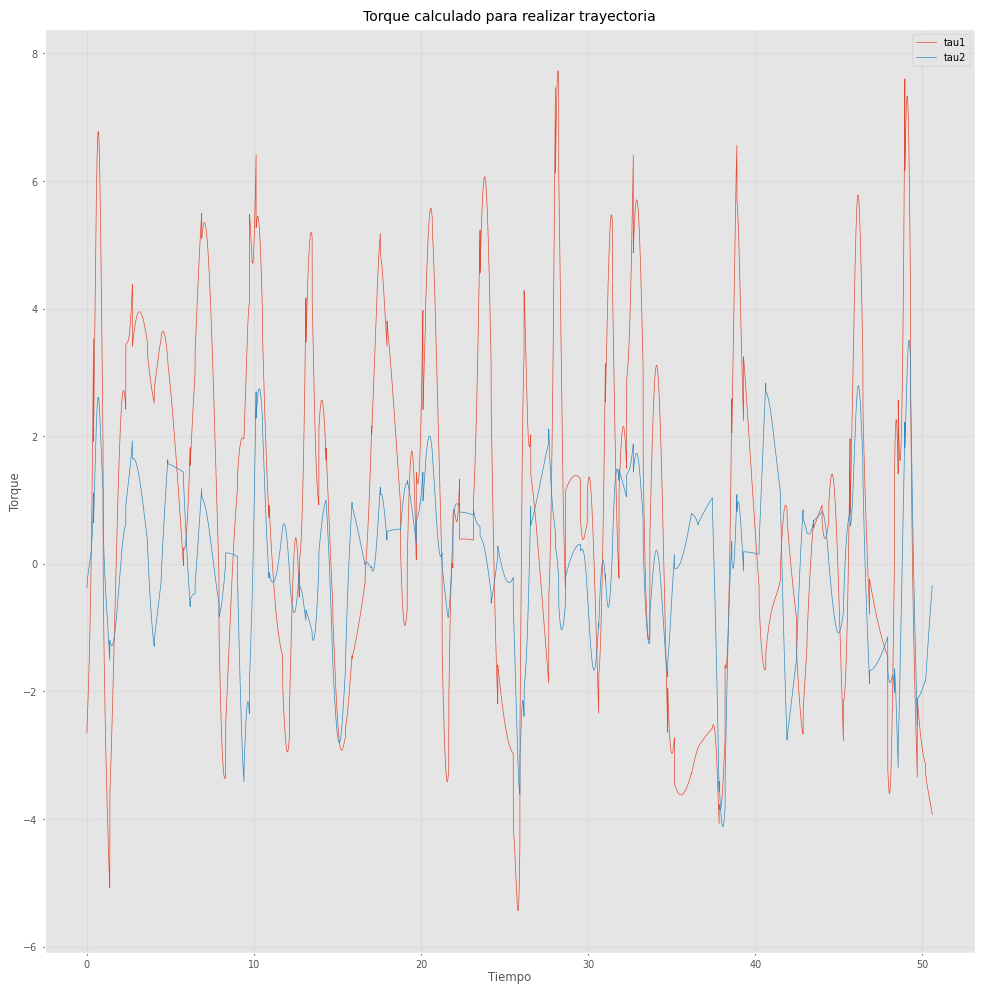

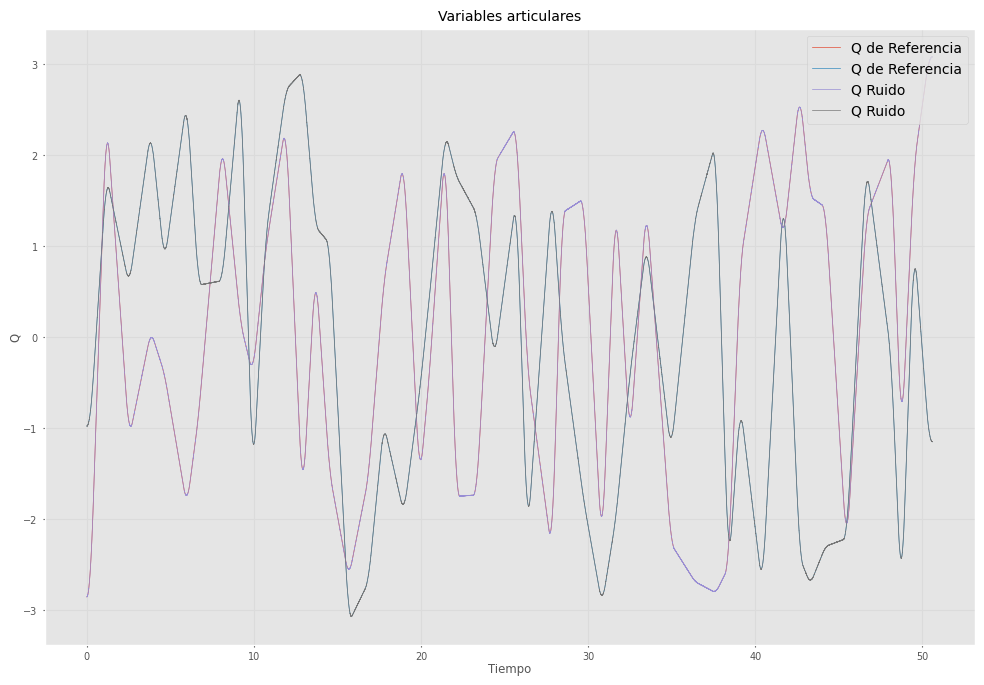

In [31]:
t_ref, q_ref, qd_ref, qdd_ref, POSES_ref, tau_ref, q_ref_noise = generateRandomDataSet(dp,50,flag_joint_move=True,flag_plot=True,flag_q_noise=True, pos_noise_std=1e-3)

In [32]:
nombre_archivo = f'./2lpr_noise_jointmovement_{fecha_actual}.csv'

cantidad = len(t_ref)

if not os.path.isfile(nombre_archivo) or os.path.getsize(nombre_archivo) == 0:
    # Si el archivo no existe o está vacío, escribir las cabeceras CSV
    with open(nombre_archivo, 'w') as archivo:
        archivo.write('ID, Time, Theta_1, Theta_2, D_Theta_1, D_Theta_2, DD_Theta_1, DD_Theta_2, Torque_1, Torque_2, Theta_N_1, Theta_N_2\n')
        #Length_1, Length_2, Alpha_1, Alpha_2 Mass_1, Mass_2, B_1, B_2, G_1, G_2
with open(nombre_archivo, 'a') as archivo:
    for _ in range(cantidad):
        id = _ +1
        time = t_ref[_]
        j_1 = q_ref[_][0]
        j_2 = q_ref[_][1]
        d_j_1 = qd_ref[_][0]
        d_j_2 = qd_ref[_][1]
        dd_j_1 = qdd_ref[_][0]
        dd_j_2 = qdd_ref[_][1]
        tau_1 = tau_ref[_][0]
        tau_2 = tau_ref[_][1]
        j_1_noise = q_ref_noise[_][0]
        j_2_noise = q_ref_noise[_][1]

        archivo.write(f'{id}, {time}, {j_1}, {j_2}, {d_j_1}, {d_j_2}, {dd_j_1}, {dd_j_2}, {tau_1}, {tau_2}, {j_1_noise}, {j_2_noise}\n')